In [1]:
import os
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.7,convert_system_message_to_human=True)
from langchain_core.tools import tool
@tool
def search(query: str):
    """Call to surf the web."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

c:\Users\DELL\langchain\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tools = [search]
tool_node = ToolNode(tools)

In [8]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [4]:
from typing import Literal
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [6]:
workflow=StateGraph(MessagesState)


In [9]:
workflow.add_node("agent",call_model)
workflow.add_node("tools",call_model)


In [10]:
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)
workflow.set_entry_point("agent")
# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

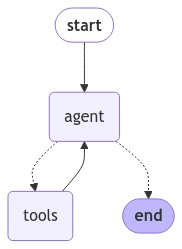

In [11]:
checkpointer = MemorySaver()
app=workflow.compile(checkpointer=checkpointer)
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
from langchain_core.messages import HumanMessage
# Use the Runnable
final_state = app.invoke({"messages": [HumanMessage(content="what is the tomorrow weather in sf?")]},config={"configurable": {"thread_id": 42}})

c:\Users\DELL\langchain\venv\lib\site-packages\langchain_google_genai\chat_models.py:381: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
